# Data Ingest and Benchmark

This notebook demonstrates GPU-accelerated telemetry loading with cuDF and Unified Virtual Memory (UVM), and benchmarks **pandas** (CPU), **cuDF** (native GPU API), and **cudf.pandas** (pandas API on GPU, zero code change). Inspired by [Speed Up Data Analytics on GPUs](https://developers.google.com/learn/pathways/speed-up-data-analytics-GPUs).

<a href="https://colab.research.google.com/github/KarthikSriramGit/H.E.I.M.D.A.L.L/blob/main/notebooks/01_data_ingest_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/H.E.I.M.D.A.L.L.git")
    get_ipython().run_line_magic("cd", "H.E.I.M.D.A.L.L")
    get_ipython().system("pip install -q pandas pyarrow numpy matplotlib")
    get_ipython().system("pip install -q cudf-cu12 2>/dev/null || true")
except Exception:
    pass

/content/H.E.I.M.D.A.L.L
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 9.0 MB/s eta 0:00:00


In [2]:
# Setup: Colab runs from repo root after clone
import sys
from pathlib import Path
ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

ROOT=/content/H.E.I.M.D.A.L.L


## Generate synthetic telemetry

In [3]:
# Generate synthetic telemetry (2M rows for meaningful cuDF benchmark)
import subprocess
parquet_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
ROWS = 2_000_000
if not parquet_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", str(ROWS),
        "--output-dir", "data/synthetic",
        "--format", "parquet",
    ], check=True, cwd=str(ROOT))
    print(f"Generated {ROWS:,} rows")
else:
    print(f"Data exists: {parquet_path} (delete to regenerate with {ROWS:,} rows)")

Generated 2,000,000 rows


## Load with cuDF and UVM spill

The telemetry uses a **unified flat schema**: all 5 sensor types (IMU, LiDAR, CAN, GPS, Camera) share one table. Columns that don't apply to a given sensor type are `<NA>`: for example, an IMU row has no `brake_pressure_pct`, and a CAN row has no `accel_x`. This is normal for a wide Parquet table optimized for columnar access.

Below we load the full dataset, then show **per-sensor views** with only the relevant columns so the data is easy to read.

In [4]:
from src.ingest.cudf_loader import load_telemetry
from src.ingest.telemetry_schema import get_columns_for_sensor, SENSOR_TYPES

df = load_telemetry(str(parquet_path), spill=True)
backend = "cuDF" if "cudf" in str(type(df)) else "pandas"
print(f"Full dataset shape: {df.shape}  |  Backend: {backend}")
# For cuDF string columns, .unique() can raise cupy/object errors; use to_pandas() first
st_col = df["sensor_type"]
if hasattr(st_col, "to_pandas"):
    unique_types = st_col.to_pandas().unique().tolist()
else:
    unique_types = st_col.unique().tolist()
print(f"Sensor types: {unique_types}")
print(f"\nRows per sensor type:")
# For cuDF string columns, value_counts() can raise cupy/object errors; use to_pandas() first
st_col = df["sensor_type"]
if hasattr(st_col, "to_pandas"):
    counts = st_col.to_pandas().value_counts()
else:
    counts = st_col.value_counts()
print(counts.to_string())
print()

# Per-sensor views: only show columns relevant to each sensor (no <NA> clutter)
for stype in SENSOR_TYPES:
    cols = get_columns_for_sensor(stype)
    cols = [c for c in cols if c in df.columns]
    subset = df[df["sensor_type"] == stype][cols]
    print(f"--- {stype.upper()} ({len(subset):,} rows, {len(cols)} columns) ---")
    sample = subset.head(3)
    if hasattr(sample, "to_pandas"):
        sample = sample.to_pandas()
    print(sample.to_string(index=False))
    print()

Full dataset shape: (2000000, 33)  |  Backend: cuDF
Sensor types: ['imu', 'gps', 'lidar', 'can', 'camera']

Rows per sensor type:
sensor_type
imu       400000
gps       400000
lidar     400000
can       400000
camera    400000

--- IMU (400,000 rows, 13 columns) ---
 timestamp_ns vehicle_id sensor_type   accel_x   accel_y  accel_z    gyro_x    gyro_y    gyro_z  orientation_w  orientation_x  orientation_y  orientation_z
            0       V003         imu  0.180772  0.245564 9.980300  0.003394 -0.015557  0.015335       0.997466       0.014094      -0.003564       0.004729
            0       V008         imu  0.405369  0.441064 9.902590 -0.000811  0.004151  0.017944       0.990591      -0.008402       0.006928       0.009211
    216000540       V008         imu -0.198405 -0.010305 9.881881  0.002286 -0.018714 -0.022012       0.997044       0.001753      -0.000083       0.000752

--- LIDAR (400,000 rows, 8 columns) ---
 timestamp_ns vehicle_id sensor_type  point_count  min_range  max_ra

## Per-sensor summary statistics

Quick stats for each sensor type using only their relevant numeric columns (no NA noise).

In [5]:
for stype in SENSOR_TYPES:
    cols = get_columns_for_sensor(stype)
    cols = [c for c in cols if c in df.columns]
    subset = df[df["sensor_type"] == stype][cols]
    # Only describe numeric columns
    if hasattr(subset, "to_pandas"):
        desc = subset.to_pandas().describe()
    else:
        desc = subset.describe()
    print(f"--- {stype.upper()} summary ---")
    print(desc.to_string())
    print()

--- IMU summary ---
       timestamp_ns        accel_x        accel_y        accel_z         gyro_x        gyro_y         gyro_z  orientation_w  orientation_x  orientation_y  orientation_z
count  4.000000e+05  400000.000000  400000.000000  400000.000000  400000.000000  4.000000e+05  400000.000000  400000.000000  400000.000000  400000.000000  400000.000000
mean   4.318571e+13      -0.000312       0.001059       9.810193       0.000005  6.265601e-08       0.000022       0.994997       0.000004      -0.000005       0.000012
std    2.493852e+13       0.500177       0.499550       0.200025       0.009993  1.000873e-02       0.009981       0.002889       0.009998       0.010004       0.009979
min    0.000000e+00      -2.413561      -2.295935       8.792851      -0.046254 -5.043590e-02      -0.044266       0.990000      -0.045217      -0.052212      -0.051977
25%    2.155804e+13      -0.336078      -0.335753       9.674906      -0.006737 -6.747558e-03      -0.006703       0.992493      -0.006

## Benchmark: pandas vs cuDF vs cudf.pandas

Compares load, groupby, filter, and sort on the full unified table.
- **pandas**: CPU baseline.
- **cuDF**: Native GPU API with UVM spill.
- **cudf.pandas**: RAPIDS drop-in—same pandas code, runs on GPU (zero code change).
- **groupby** aggregates `brake_pressure_pct` per vehicle (CAN rows; NAs from other sensors are skipped automatically).
- **filter** selects rows where `brake_pressure_pct > 90` (hard braking events).
- Time is wall-clock; memory is CPU RAM only (cuDF and cudf.pandas use GPU VRAM, so their memory bars reflect host allocation, not GPU).

In [6]:
from src.ingest.benchmark_loader import run_benchmark, benchmark_to_dataframe

results = run_benchmark(parquet_path)
bm_df = benchmark_to_dataframe(results)
print(bm_df)

        backend operation    time_s   memory_mb
0        pandas      load  1.018777  105.534498
1        pandas   groupby  0.238275   62.776553
2        pandas    filter  0.033355   12.586584
3        pandas      sort  0.343612  534.062752
4          cudf      load  0.163492    0.236081
5          cudf   groupby  0.009923    0.032921
6          cudf    filter  0.015538    0.213394
7          cudf      sort  0.026713    0.222084
8   cudf_pandas      load  0.162825    0.236897
9   cudf_pandas   groupby  0.041996    0.227306
10  cudf_pandas    filter  0.018582    0.212257
11  cudf_pandas      sort  0.029186    0.226532


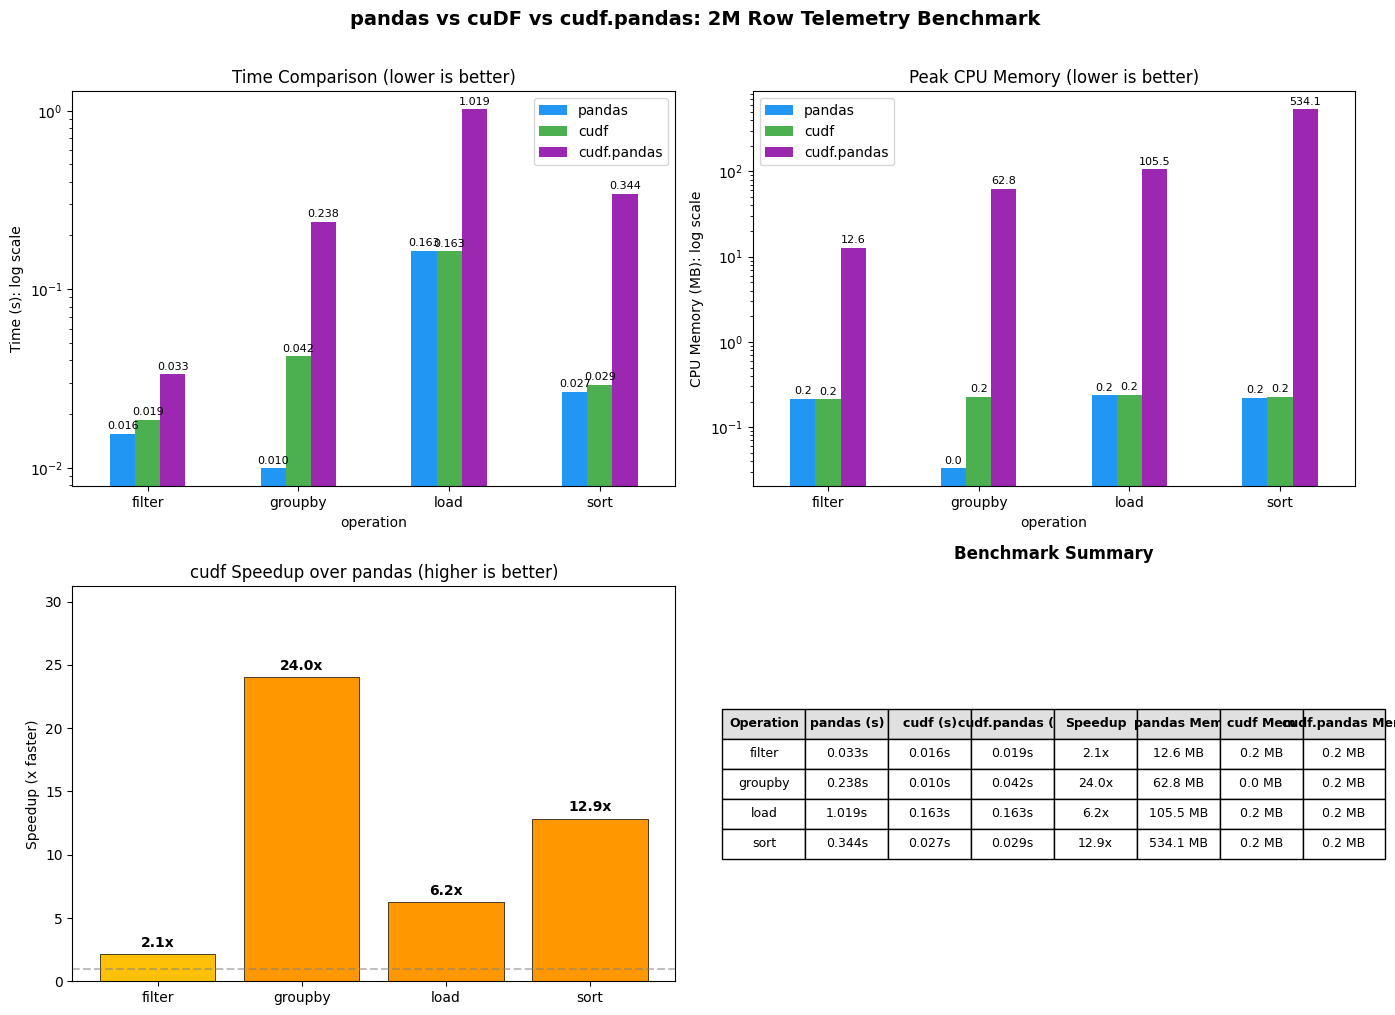

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

pivot_time = bm_df.pivot(index="operation", columns="backend", values="time_s")
pivot_mem = bm_df.pivot(index="operation", columns="backend", values="memory_mb")

operations = pivot_time.index.tolist()
backends = [c for c in ["pandas", "cudf", "cudf_pandas"] if c in pivot_time.columns]
# Colors: pandas (blue), cuDF (green), cudf.pandas (purple)
backend_colors = {"pandas": "#2196F3", "cudf": "#4CAF50", "cudf_pandas": "#9C27B0"}
colors = [backend_colors.get(b, "#757575") for b in backends]
# Ensure pivot column order matches backends so bar colors and legend align
pivot_time = pivot_time[backends]
pivot_mem = pivot_mem[backends]
has_gpu = "cudf" in backends or "cudf_pandas" in backends

# Speedup vs pandas for first GPU backend
gpu_backend = "cudf" if "cudf" in backends else ("cudf_pandas" if "cudf_pandas" in backends else None)
if gpu_backend:
    time_speedup = pivot_time["pandas"] / pivot_time[gpu_backend]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Time comparison (log scale so GPU bars are visible)
# No bar labels on grouped bars to avoid overlap when values are close
pivot_time.plot(kind="bar", ax=axes[0, 0], rot=0, color=colors)
axes[0, 0].set_ylabel("Time (s): log scale")
axes[0, 0].set_yscale("log")
axes[0, 0].set_title("Time Comparison (lower is better)")
axes[0, 0].legend([b.replace("_", ".") for b in backends])
axes[0, 0].set_xlabel("")

# Top right: Memory comparison (log scale)
pivot_mem.plot(kind="bar", ax=axes[0, 1], rot=0, color=colors)
axes[0, 1].set_ylabel("CPU Memory (MB): log scale")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Peak CPU Memory (lower is better)")
axes[0, 1].legend([b.replace("_", ".") for b in backends])
axes[0, 1].set_xlabel("")

# Bottom left: Speedup factor bars (pandas vs first GPU backend)
if has_gpu and gpu_backend:
    colors = ["#FF9800" if s >= 5 else "#FFC107" for s in time_speedup]
    bars = axes[1, 0].bar(operations, time_speedup, color=colors, edgecolor="black", linewidth=0.5)
    axes[1, 0].set_ylabel("Speedup (x faster)")
    axes[1, 0].set_title(f"{gpu_backend.replace('_', '.')} Speedup over pandas (higher is better)")
    axes[1, 0].axhline(y=1, color="gray", linestyle="--", alpha=0.5)
    axes[1, 0].bar_label(bars, fmt="%.1fx", fontsize=10, fontweight="bold", padding=3)
    axes[1, 0].set_ylim(bottom=0, top=float(max(time_speedup)) * 1.3)
else:
    axes[1, 0].text(0.5, 0.5, "cuDF not available", ha="center", va="center",
                     transform=axes[1, 0].transAxes, fontsize=14)
    axes[1, 0].set_title("GPU Speedup (N/A)")

# Bottom right: Summary as styled DataFrame (clean, no overlap)
axes[1, 1].axis("off")
if backends:
    def _short(b):
        return "cudf.pd" if b == "cudf_pandas" else b.replace("_", ".")
    # Build wide-format summary DataFrame
    summary_rows = []
    for op in operations:
        row = {"Operation": op}
        for b in backends:
            row[f"{_short(b)} (s)"] = pivot_time.loc[op, b]
        if gpu_backend:
            row["Speedup"] = pivot_time.loc[op, "pandas"] / pivot_time.loc[op, gpu_backend]
        for b in backends:
            row[f"{_short(b)} (MB)"] = pivot_mem.loc[op, b]
        summary_rows.append(row)
    summary_df = pd.DataFrame(summary_rows)
    # Display styled table in the axes area via table - but use HTML-style for cleaner look
    # Use a minimal text table to avoid matplotlib table overlap; display full df below
    axes[1, 1].text(0.5, 0.5, "Summary table below", ha="center", va="center", fontsize=12, color="#666")

fig.suptitle("pandas vs cuDF vs cudf.pandas: 2M Row Telemetry Benchmark", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# Styled summary table (renders below the figure, no overlap)
if backends:
    fmt = {c: "{:.3f}s" for c in summary_df.columns if c.endswith(" (s)")}
    fmt.update({c: "{:.1f}x" for c in summary_df.columns if c == "Speedup"})
    fmt.update({c: "{:.1f}" for c in summary_df.columns if c.endswith(" (MB)")})
    display(summary_df.style
        .format(fmt, na_rep="-")
        .set_properties(**{"text-align": "right"})
        .set_properties(subset=["Operation"], **{"text-align": "left"})
        .set_caption("Benchmark Summary")
        .set_table_styles([
            {"selector": "caption", "props": [("font-weight", "bold"), ("font-size", "13px")]},
            {"selector": "th", "props": [("background-color", "#37474F"), ("color", "white"), ("padding", "10px 12px")]},
            {"selector": "td", "props": [("padding", "8px 12px")]},
            {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f5f5f5")]},
        ])
    )